In [1]:
# -*- coding: utf-8 -*-

## Map Generalization for Polygons using Autoencode-like strucutures
## Adatped based on Master Thesis of SERCAN CAKIR "ROAD NETWORK EXTRACTION USING CNN"
## Author: Yu Feng, yuzz.feng@gmail.com
## 1. Version Author: SERCAN CAKIR

## Changes:
## 1. Two conv layers were added before the first down convlusional layer
## 2. Output can be any size during the evaluation
## 3. Adapt the code to support more images as training examples
## 4. Dropouot may make the sharpe corners vanishing, we delete half of them, but we should used some
## 5. 

import matplotlib
#matplotlib.use('Agg') # necessary for linux kernal
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
from numpy import random
np.random.seed(7)
import keras
from keras.models import Sequential
from keras.callbacks import History
from keras.layers.core import Dropout
#from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation
from keras import backend as K

from keras.models import Model
from keras.layers import Input, Conv2D, Dropout, UpSampling2D, Activation, Concatenate

from osgeo import gdal
from sklearn.model_selection import train_test_split
from skimage.util.shape import view_as_windows

from data_helper import readImg, readImgInv, imagePatches, removeBlackImg, removeCorrespondence

from time import gmtime, strftime
timestr = strftime("%Y-%m-%d %H-%M-%S", gmtime())

def check_and_create(out_dir):
    if os.path.isdir(out_dir) == False:
        os.mkdir(out_dir)

def prediction_independent(model_ex1, image_arr):
    
    conc2 = np.reshape(model_ex1.predict(np.reshape(image_arr, (1, image_arr.shape[0], image_arr.shape[1], 1))), 
                   (image_arr.shape[0], image_arr.shape[1]))
    return conc2

# cut the image to avoid shape error
def cut_image(image_arr):
    
    print("Original:", image_arr.shape)
    
    if image_arr.shape[0] % 4 != 0:
        n = image_arr.shape[0] % 4
        new_x = image_arr.shape[0] - n
    else:
        new_x = image_arr.shape[0]

    if image_arr.shape[1] % 4 != 0:
        n = image_arr.shape[1] % 4
        new_y = image_arr.shape[1] - n
    else:
        new_y = image_arr.shape[1]
    
    image_arr = image_arr[:new_x, :new_y]
    print("Clipped:", image_arr.shape)


############ Path Setting ##############

trainPath = r"Data/Training_Validation/"
testPath = r"Data/Testing/"
  
tmpPath = r"../tmp_data/"

outPath = r"Prediction/"
check_and_create(outPath + timestr)
outPath = outPath + timestr + "/"

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# function to load a saved model
def LoadModel(model_json):
    from keras.models import model_from_json
    json_file = open(model_json)
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model


##### function to calculate evaluation parameters (F1-Score, Precision, Recall) ######
def evaluation(model, x_test, y_test, patch_size):
    precision = []
    recall = []
    f1Score = []
    import math
    for k in range(len(x_test_sim)):
        y_pred = model.predict(x_test_sim[k:k + 1])
        y_pred = np.reshape(y_pred, (32 * 32))

        y_true = y_test_sim[k:k + 1]
        y_true = np.reshape(y_true, (32 * 32))

        TP = 0
        FP = 0
        FN = 0
        TN = 0

        y_pred = np.round(y_pred)
        for i in range(len(y_pred)):
            if y_true[i] == y_pred[i] == 1:
                TP += 1
            elif y_pred[i] == y_true[i] == 0:
                TN += 1
            elif y_pred[i] == 1 and y_true[i] != y_pred[i]:
                FP += 1
            elif y_pred[i] == 0 and y_true[i] != y_pred[i]:
                FN += 1

        precision.append(TP / (TP + FP + K.epsilon()))  # completeness
        recall.append(TP / (TP + FN))  # correctness
        beta = 1
        f1Score.append((math.pow(beta, 2) + 1) * TP / ((math.pow(beta, 2) + 1) * TP + math.pow(beta, 2) * FN + FP))
        # eval_list = [precision,  recall, f1Score]

    avg_precision = sum(precision) / len(precision)
    avg_recall = sum(recall) / len(precision)
    avg_f1score = sum(f1Score) / len(precision)
    avg_eval_param = [avg_precision, avg_recall, avg_f1score]
    return avg_eval_param

## Models

In [3]:
## Building the CNN archıtecture with "Sequential Model" (model looks like autoencoder)
## Version with batch normalozation - Do not benifit that much

def create_model_batch(optimizer, input_shape):
    
    model = Sequential()
    droprate = 0.3
    
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              input_shape=input_shape, kernel_initializer='random_uniform', name="flat_conv_a"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same', name="flat_conv_b"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    ## Encoding (down-sampling) ###   
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     name="down_conv_1"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_1"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_2"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    ## Encoding (down-sampling) ### 
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     name="down_conv_2"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_3"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_4"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_5"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_6"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_6a"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_6b"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_6c"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_7"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_8"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_1'))
    
    model.add(Conv2D(filters=64, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     name="up_conv_1"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_9"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_10"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_2'))

    model.add(Conv2D(filters=24, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     name="up_conv_2"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=12, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_11"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=1, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='sigmoid', name="flat_conv_12"))
    # model.add(Activation(our_activation))
    model.add(Dropout(droprate))

    # Compile model with Adam optimizer and binary cross entropy loss function
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

In [4]:
##### Building the CNN archıtecture with "Sequential Model" 
##### (model looks like autoencoder)
def create_model(optimizer, input_shape):
    model = Sequential()
    
    droprate = 0.3

    model.add(Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              activation='relu', input_shape=input_shape, kernel_initializer='random_uniform',
              name="flat_conv_a"))
    #model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              activation='relu',name="flat_conv_b"))
    #model.add(Dropout(droprate))
    
#    model.add(Conv2D(filters=24, kernel_size=(3, 3),
#              strides=(1, 1), padding='same',
#              activation='relu',name="flat_conv_c"))
#    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
#    model.add(Dropout(droprate))
    
    ## Encoding (down-sampling) ###   
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu', #input_shape=input_shape, kernel_initializer='random_uniform',
                     name="down_conv_1"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_1"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_2"))
    #model.add(Dropout(droprate))
    ##############################################################################
    
#    model.add(Conv2D(filters=24, kernel_size=(3, 3),
#              strides=(1, 1), padding='same',
#              activation='relu',name="down_conv_2"))
#    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
#    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu', name="down_conv_2"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_3"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_4"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_5"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_6"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_7"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_8"))
    model.add(Dropout(droprate))
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_1'))
    
#    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), 
#                              padding='same', activation='softmax'))
    

    model.add(Conv2D(filters=64, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_1"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_9"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_10"))
    #model.add(Dropout(droprate))
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_2'))
    
#    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), # Lead the accuracy to 0.78
#                              padding='same', activation='softmax'))

    model.add(Conv2D(filters=24, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_2"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=12, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_11"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=1, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='sigmoid', name="flat_conv_12"))
    # model.add(Activation(our_activation))
    #model.add(Dropout(droprate))

    # Compile model with Adam optimizer and binary cross entropy loss function
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    
    return model


##################################################################################################################################
class LearningRateTracker(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.lr_list = []

    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        # lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        lr = K.eval(
            optimizer.lr * (1. / (1. + optimizer.decay * K.cast(optimizer.iterations, K.dtype(optimizer.decay)))))
        print('\n LR: {}\n'.format(lr))
        self.lr_list.append(lr)

##################################################################################################################################
class SaveWeights(keras.callbacks.Callback):  # Saves weights after each 25 epochs
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 49 == 0:
            model_json = self.model.to_json()
            with open("model_" + str(epoch) + ".json", "w") as json_file:
                json_file.write(model_json)
            self.model.save_weights("weights_model_" + str(epoch) + ".h5")
            print("Saved model-weights to disk")

##################################################################################################################################

In [5]:
##### Building the CNN archıtecture with "Model" - skip connections were added
def create_model_add_skips(optimizer, input_shape, drop_rate = 0.3):

    
    i = Input(shape=input_shape)
    
    
    x = Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              activation='relu', input_shape=input_shape, kernel_initializer='random_uniform',
              name="flat_conv_a")(i)
    first_skip = Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              activation='relu',name="flat_conv_b")(x)
    x = Conv2D(filters=24, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu',
                     name="down_conv_1")(first_skip)
    x = Dropout(drop_rate)(x) ################################################# First Drop
    
    
    
    x = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_1")(x)
    second_skip = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_2")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu', name="down_conv_2")(second_skip)
    x = Dropout(drop_rate)(x) ################################################# Second Drop
    
    
    
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_3")(x)
    third_skip = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_4")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu', name="down_conv_3")(third_skip)
    x = Dropout(drop_rate)(x) ################################################# Third Drop
    
    
    
    x = Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_5")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_6")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_7")(x)
    x = Dropout(drop_rate)(x) ################################################# 4th Drop
    
    
    x = UpSampling2D(size=(2, 2), name='up_samp_0')(x)
    x = Conv2D(filters=128, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_0")(x)
    concat0 = Concatenate()([third_skip, x])
    x = Conv2D(filters=128, kernel_size=(1, 1),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_8")(concat0)
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_8b")(x)
    x = Dropout(drop_rate)(x) ################################################# 5th Drop
    
    
    x = UpSampling2D(size=(2, 2), name='up_samp_1')(x)
    x = Conv2D(filters=64, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_1")(x)
    concat = Concatenate()([second_skip, x])
    x = Conv2D(filters=64, kernel_size=(1, 1),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_9")(concat)
    x = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_10")(x)
    x = Dropout(drop_rate)(x) ################################################# 6th Drop
    
    
    x = UpSampling2D(size=(2, 2), name='up_samp_2')(x)
    x = Conv2D(filters=24, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_2")(x)
    concat2 = Concatenate()([first_skip, x])
    x = Conv2D(filters=12, kernel_size=(1, 1),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_11")(concat2)
    x = Conv2D(filters=12, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_11b")(x)
    x = Dropout(drop_rate)(x) ################################################# 7th Drop
    
    
    o = Conv2D(filters=1, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='sigmoid', name="flat_conv_12")(x)
    model = Model(inputs=i, outputs=o)

    # Compile model with Adam optimizer and binary cross entropy loss function
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

In [6]:
##### Building the CNN archıtecture with "Model" - skip connections were added
def create_model_add_skips_2(optimizer, input_shape, drop_rate = 0.3):

    
    i = Input(shape=input_shape)
    
    
    x = Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              activation='relu', input_shape=input_shape, kernel_initializer='random_uniform',
              name="flat_conv_a")(i)
    first_skip = Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              activation='relu',name="flat_conv_b")(x)
    x = Conv2D(filters=24, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu',
                     name="down_conv_1")(first_skip)
    #x = Dropout(drop_rate)(x) ################################################# First Drop
    
    
    
    x = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_1")(x)
    second_skip = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_2")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu', name="down_conv_2")(second_skip)
    #x = Dropout(drop_rate)(x) ################################################# Second Drop
    
    
    
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_3")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_4")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="xx_conv_3")(x)
    #x = Dropout(drop_rate)(x) ################################################# Third Drop
    
    
    
    x = Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_5")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_6")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_7")(x)
    x = Dropout(drop_rate)(x) ################################################# 4th Drop
    
    

    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="xx_conv_0")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_8")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_8b")(x)
    x = Dropout(drop_rate)(x) ################################################# 5th Drop
    
    
    x = UpSampling2D(size=(2, 2), name='up_samp_1')(x)
    x = Conv2D(filters=64, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_1")(x)
    concat = Concatenate()([second_skip, x])
    x = Conv2D(filters=64, kernel_size=(1, 1),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_9")(concat)
    x = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_10")(x)
    x = Dropout(drop_rate)(x) ################################################# 6th Drop
    
    
    x = UpSampling2D(size=(2, 2), name='up_samp_2')(x)
    x = Conv2D(filters=24, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_2")(x)
    concat2 = Concatenate()([first_skip, x])
    x = Conv2D(filters=12, kernel_size=(1, 1),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_11")(concat2)
    x = Conv2D(filters=12, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_11b")(x)
    x = Dropout(drop_rate)(x) ################################################# 7th Drop
    
    
    o = Conv2D(filters=1, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='sigmoid', name="flat_conv_12")(x)
    model = Model(inputs=i, outputs=o)

    # Compile model with Adam optimizer and binary cross entropy loss function
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

## Prepare Training Data

Number of tiles:  16828
15828 1000 15828 1000
Input Shape of the models (15828, 128, 128, 1)


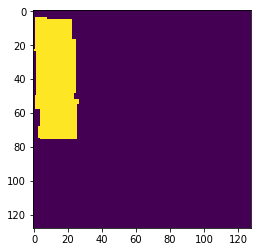

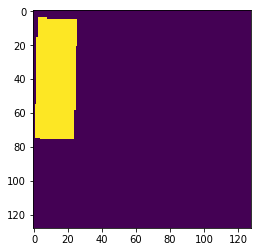

In [7]:
# Order the image dimension acc. to TensorFlow (batc_hsize, rows, cols, channels)
K.set_image_dim_ordering('tf')

# set the working directory
#os.chdir(r'F:\sercan\input_images')
PATH = os.getcwd()
#plt.gray()
#plt.show()


p_size_1 = 128 # Compared with 256, which larger may generate round corners

def data_collector(fns_input, fns_output):
    
    sim_input = []
    sim_output = []
    
    for fn_input, fn_output in zip(fns_input, fns_output):
        
        # load simulated heat map (TRAJECTORY SIMULATION) and target road for Hannover ####
        sim_heatmap_hannover = readImg(fn_input)
        sim_road_hannover = readImg(fn_output)
        
        sim_hm_patches_overlap = imagePatches(sim_heatmap_hannover, p_size_1, p_size_1, int(p_size_1))
        sim_road_patches_overlap = imagePatches(sim_road_hannover, p_size_1, p_size_1, int(p_size_1))
        sim_road_patches_overlap_new = removeCorrespondence(sim_road_patches_overlap, sim_hm_patches_overlap)
        sim_hm_patches_overlap_new = removeCorrespondence(sim_hm_patches_overlap, sim_road_patches_overlap)
        sim_road_patches_overlap_new_new = removeBlackImg(sim_road_patches_overlap)
        
        sim_input += sim_hm_patches_overlap_new
        sim_output += sim_road_patches_overlap_new_new
    
    return sim_input, sim_output

fns_input = [trainPath + r"traininput_inv.png"]
fns_output = [trainPath + r"trainoutput_inv.png"]

#fns_input = [r"data/input2.tif"]#, r"data/geb1_inp_inv_cut.tif"]
#fns_output = [r"data/output2.tif"]#, r"data/geb1_out_inv_cut.tif"]

sim_hm_patches_32_new, sim_road_patches_32_new_new = data_collector(fns_input, fns_output)
print('Number of tiles: ', len(sim_hm_patches_32_new))

#### experience 1 - simulated hm
index_list_sim = list(range(len(sim_hm_patches_32_new)))
random.shuffle(index_list_sim)

idx_sim = 1000
index_list_test_sim = index_list_sim[-idx_sim:]
index_list_test_sim.sort()
sim_hm_test = [sim_hm_patches_32_new[i] for i in index_list_test_sim]
sim_road_test = [sim_road_patches_32_new_new[i] for i in index_list_test_sim]

index_list_train_sim = index_list_sim[:-idx_sim]
index_list_train_sim.sort()
sim_hm_train = [sim_hm_patches_32_new[i] for i in index_list_train_sim]
sim_road_train = [sim_road_patches_32_new_new[i] for i in index_list_train_sim]

from sklearn.model_selection import train_test_split
#sim_hm_train, sim_hm_test, sim_road_train, sim_road_test = train_test_split(sim_hm_patches_32_new, 
#                                                                            sim_road_patches_32_new_new,
#                                                                            test_size=0.33, random_state=42)

print(len(sim_hm_train), len(sim_hm_test), len(sim_road_train), len(sim_road_test))

x_train_sim = np.reshape(sim_hm_train, (len(sim_hm_train), p_size_1, p_size_1, 1))
y_train_sim = np.reshape(sim_road_train, (len(sim_road_train), p_size_1, p_size_1, 1))
x_test_sim = np.reshape(sim_hm_test, (len(sim_hm_test), p_size_1, p_size_1, 1))
y_test_sim = np.reshape(sim_road_test, (len(sim_road_test), p_size_1, p_size_1, 1))

# save image patch arrays
np.save(tmpPath + "x_train_sim.npy", x_train_sim)
np.save(tmpPath + "y_train_sim.npy", y_train_sim)
np.save(tmpPath + "x_test_sim.npy", x_test_sim)
np.save(tmpPath + "y_test_sim.npy", y_test_sim)

plt.figure()
plt.imshow(np.reshape(x_test_sim[2], (p_size_1,p_size_1)))
plt.figure()
plt.imshow(np.reshape(y_test_sim[2], (p_size_1,p_size_1)))

input_shape1 = (None, None, 1) #x_train_sim[0].shape
print('Input Shape of the models', x_train_sim.shape)



In [ ]:
opt1 = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)


#model_ex1 = create_model(opt1, input_shape1)

#model_ex1 = create_model_batch(opt1, input_shape1)

#model_ex1 = create_model_add_skips(opt1, input_shape1)

model_ex1 = create_model_add_skips_2(opt1, input_shape1)

model_ex1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
flat_conv_a (Conv2D)            (None, None, None, 2 240         input_1[0][0]                    
__________________________________________________________________________________________________
flat_conv_b (Conv2D)            (None, None, None, 2 5208        flat_conv_a[0][0]                
__________________________________________________________________________________________________
down_conv_1 (Conv2D)            (None, None, None, 2 5208        flat_conv_b[0][0]                
__________________________________________________________________________________________________
flat_conv_

## Training

In [ ]:
##### Train the model
#covariance1 = Covariance()
History1 = History()
hist1 = model_ex1.fit(x_train_sim, y_train_sim,
                      batch_size=16,
                      epochs = 80,
                      verbose=1,
                      shuffle=True,
                      callbacks=[History1],
                      validation_data=(x_test_sim, y_test_sim))

Train on 15828 samples, validate on 1000 samples
Epoch 1/80
15828/15828 [==============================] - 84s 5ms/step - loss: 0.0849 - acc: 0.9821 - val_loss: 0.0426 - val_acc: 0.9885
Epoch 2/80
15828/15828 [==============================] - 80s 5ms/step - loss: 0.0459 - acc: 0.9880 - val_loss: 0.0394 - val_acc: 0.9893
Epoch 3/80
15828/15828 [==============================] - 80s 5ms/step - loss: 0.0438 - acc: 0.9887 - val_loss: 0.0378 - val_acc: 0.9896
Epoch 4/80
15828/15828 [==============================] - 80s 5ms/step - loss: 0.0423 - acc: 0.9890 - val_loss: 0.0381 - val_acc: 0.9897
Epoch 5/80
15828/15828 [==============================] - 80s 5ms/step - loss: 0.0412 - acc: 0.9892 - val_loss: 0.0361 - val_acc: 0.9898
Epoch 6/80
15828/15828 [==============================] - 80s 5ms/step - loss: 0.0403 - acc: 0.9893 - val_loss: 0.0351 - val_acc: 0.9898
Epoch 7/80
15828/15828 [==============================] - 80s 5ms/step - loss: 0.0394 - acc: 0.9893 - val_loss: 0.0377 - val_acc:

In [ ]:
### Save history
History1_loss = History1.history['loss']
History1_acc = History1.history['acc']
History1_val_loss = History1.history['val_loss']
History1_val_acc = History1.history['val_acc']


thefile1 = open(outPath + 'History1_loss.txt', 'w')
for item in History1_loss:
    thefile1.write("%s\n" % item)
thefile1.close()

thefile2 = open(outPath + 'History1_acc.txt', 'w')
for item in History1_acc:
    thefile2.write("%s\n" % item)
thefile2.close()

thefile3 = open(outPath + 'History1_val_loss.txt', 'w')
for item in History1_val_loss:
    thefile3.write("%s\n" % item)
thefile3.close()

thefile4 = open(outPath + 'History1_val_acc.txt', 'w')
for item in History1_val_acc:
    thefile4.write("%s\n" % item)
thefile4.close()

### Save model
model_json1 = model_ex1.to_json()
with open(tmpPath + "model_ex1.json", "w") as json_file:
    json_file.write(model_json1)
model_ex1.save_weights(tmpPath + "weights_model_ex1.h5")
print("Saved model to disk")

In [ ]:
### Plot history of average covariance - accuracy and loss of the models
plt.figure()
plt.plot(History1.history['loss'])
plt.plot(History1.history['val_loss'])
plt.title('loss & val_loss')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(outPath + "loss", dpi=1000)

plt.figure()
plt.plot(History1.history['acc'])
plt.plot(History1.history['val_acc'])
plt.title('acc & val_acc')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig(outPath + "acc", dpi=1000)

## Independent Test

In [ ]:
from sklearn.metrics import accuracy_score
def testIndependet(fn, inpath, outpath):
    
    image_arr = readImg(inpath + fn)
    print(image_arr.shape)
    
    if image_arr.shape[0] % 8 != 0:
        n = image_arr.shape[0] % 8
        new_x = image_arr.shape[0] - n
    else:
        new_x = image_arr.shape[0]


    if image_arr.shape[1] % 8 != 0:
        n = image_arr.shape[1] % 8
        new_y = image_arr.shape[1] - n
    else:
        new_y = image_arr.shape[1]

    image_arr = image_arr[:new_x, :new_y]
    print(image_arr.shape)
    
    conc2 = np.reshape(model_ex1.predict(np.reshape(image_arr, (1, image_arr.shape[0], image_arr.shape[1], 1))), 
                       (image_arr.shape[0], image_arr.shape[1]))
    
    print(accuracy_score(image_arr.flatten().astype(bool), (conc2 > 0.5).flatten()))
    
    fig = plt.figure(figsize=(image_arr.shape[1] / 1000, image_arr.shape[0] / 1000), dpi=100, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    plt.imshow(conc2)
    fig.savefig(outpath + fn[:-4] + '_out.png', dpi=1000)
    
    
    
    fig = plt.figure(figsize=(image_arr.shape[1] / 1000, image_arr.shape[0] / 1000), dpi=100, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    conc2 = conc2 > 0.5
    plt.imshow(conc2, cmap='gray')
    fig.savefig(outpath + fn[:-4] + '_out_bw.png', dpi=1000)
    

testIndependet(r"testexampleinput2.tif", testPath, outPath)
testIndependet(r"FTest1_input_inv.png", testPath, outPath)
testIndependet(r"FTest2_input_inv.png", testPath, outPath)


In [ ]:
image_arrA = readImg(testPath + r"FTest1_input_inv.png")
image_arrB = readImg(testPath + r"FTest1_output_inv.png")
print(accuracy_score(image_arrB.flatten().astype(bool), 
                     image_arrA.flatten().astype(bool))
     )

In [ ]:
image_arrA = readImg(testPath + r"FTest2_input_inv.png")
image_arrB = readImg(testPath + r"FTest2_output_inv.png")
print(accuracy_score(image_arrB.flatten().astype(bool), 
                     image_arrA.flatten().astype(bool))
     )